In [141]:
import random
from typing import List, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange

In [182]:
# === Core Battleship Components (Do Not Modify) ===
BOARD_SIZE = 10
SHIP_SIZES = {
    'Carrier': 5,
    'Battleship': 4,
    'Cruiser': 3,
    'Submarine': 3,
    'Destroyer': 2
}

class Ship:
    """
    Represents a ship with name, size, coordinates, and hit tracking.
    """
    def __init__(self, name: str, size: int):
        self.name = name
        self.size = size
        self.coordinates: List[Tuple[int,int]] = []
        self.hits: List[bool] = [False] * size

    def place(self, start: Tuple[int,int], orientation: str):
        r, c = start
        self.coordinates = [(
            r + (i if orientation == 'V' else 0),
            c + (i if orientation == 'H' else 0)
        ) for i in range(self.size)]

    def register_hit(self, pos: Tuple[int,int]) -> bool:
        if pos in self.coordinates:
            idx = self.coordinates.index(pos)
            self.hits[idx] = True
            return True
        return False

    def is_sunk(self) -> bool:
        return all(self.hits)

class Board:
    """
    Represents the Battleship board with ship placement and shot handling.
    """
    def __init__(self):
        # 0=empty, 1=ship, -1=miss, 2=hit
        self.grid = np.zeros((BOARD_SIZE, BOARD_SIZE), dtype=int)
        self.ships: List[Ship] = []

    def place_ships_randomly(self):
        """
        Randomly place all ships without overlap.
        """
        self.grid.fill(0)
        self.ships.clear()
        for name, size in SHIP_SIZES.items():
            placed = False
            while not placed:
                orient = random.choice(['H', 'V'])
                max_r = BOARD_SIZE - (size if orient == 'V' else 1)
                max_c = BOARD_SIZE - (size if orient == 'H' else 1)
                r, c = random.randint(0, max_r), random.randint(0, max_c)
                coords = [(
                    r + (i if orient == 'V' else 0),
                    c + (i if orient == 'H' else 0)
                ) for i in range(size)]
                if all(self.grid[x, y] == 0 for x, y in coords):
                    ship = Ship(name, size)
                    ship.coordinates = coords
                    self.ships.append(ship)
                    for x, y in coords:
                        self.grid[x, y] = 1
                    placed = True

    def receive_shot(self, pos: Tuple[int,int]) -> str:
        """
        Process a shot on the board. Returns 'Hit', 'Miss', 'Sunk', or 'Already'.
        """
        r, c = pos
        if self.grid[r, c] == 1:
            self.grid[r, c] = 2
            for ship in self.ships:
                if ship.register_hit(pos):
                    return 'Sunk' if ship.is_sunk() else 'Hit'
        elif self.grid[r, c] == 0:
            self.grid[r, c] = -1
            return 'Miss'
        return 'Already'

    def all_sunk(self) -> bool:
        """
        Check if all ships on this board are sunk.
        """
        return all(ship.is_sunk() for ship in self.ships)

class BattleShipSimulator:
    """
    Simulator for two-player Battleship games.

    Methods:
      reset() -> None
      get_observation(player: str) -> np.ndarray  # fog-of-war
      step(player: str, action: (r,c)) -> Tuple[str,bool]
      play_game(agent1, agent2) -> Tuple[str,int]
    """
    def __init__(self):
        self.boards: Dict[str, Board] = {
            'player1': Board(),
            'player2': Board()
        }
        self.turn: str = 'player1'

    def reset(self) -> None:
        """Initialize boards and set turn to player1."""
        for board in self.boards.values():
            board.place_ships_randomly()
        self.turn = 'player1'

    def get_observation(self, player: str) -> np.ndarray:
        """
        Returns the fog-of-war view of opponent's board:
        -1=miss, 2=hit, 0=unknown
        """
        opponent = 'player2' if player == 'player1' else 'player1'
        raw = self.boards[opponent].grid.copy()
        return np.where(raw < 0, -1, np.where(raw == 2, 2, 0))

    def step(self, player: str, action: Tuple[int,int]) -> Tuple[str, bool]:
        """
        Player takes action; returns (result, done).
        result: 'Hit'|'Miss'|'Sunk'|'Already'
        done: True if game ended
        """
        assert player == self.turn, f"Not {player}'s turn"
        opponent = 'player2' if player == 'player1' else 'player1'
        result = self.boards[opponent].receive_shot(action)
        done = False
        if self.boards[opponent].all_sunk():
            done = True
        else:
            self.turn = opponent
        return result, done

    def play_game(self, agent1, agent2):
        """
        Play a full game between agent1 (player1) and agent2 (player2).
        Agents receive observations via get_observation,
        return action tuples. Returns (winner, turns).
        """
        self.reset()
        agents = {'player1': agent1, 'player2': agent2}
        turns = 0
        done = False
        while not done:
            current = self.turn
            obs = self.get_observation(current)
            action = agents[current](obs)
            result, done = self.step(current, action)
            turns += 1
        winner = current
        return winner, turns


# Agents

In [185]:
# === Example Agents ===
class RandomAgent:
    def __init__(self):
        self.shots_taken: set = set()

    def reset(self):
        self.shots_taken.clear()

    def select_action(self, obs: np.ndarray) -> Tuple[int,int]:
        while True:
            rc = (random.randrange(BOARD_SIZE), random.randrange(BOARD_SIZE))
            if rc not in self.shots_taken:
                self.shots_taken.add(rc)
                return rc

# Placeholder for NEAT or other agents that can call env.step() similarly
class DummyAgent:
    def select_action(self, obs: np.ndarray) -> Tuple[int,int]:
        # always top-left (for demonstration)
        return (0,0)


In [187]:
# === Human-like Hunt-Target-Destroy Agent ===
class HumanLikeAgent:
    class Mode:
        HUNT, TARGET, DESTROY = range(3)

    def __init__(self):
        self.reset()

    def reset(self):
        # state
        self.board_view: np.ndarray = np.zeros((BOARD_SIZE, BOARD_SIZE), dtype=int)
        self.moves: List[Tuple[int,int]] = [(r,c) for r in range(BOARD_SIZE) for c in range(BOARD_SIZE)]
        self.mode = HumanLikeAgent.Mode.HUNT
        self.targets: List[Tuple[int,int]] = []
        self.last_hit: Optional[Tuple[int,int]] = None

    def select_action(self, obs: np.ndarray) -> Tuple[int,int]:
        # update board_view
        self.board_view = obs.copy()
        # remove unavailable moves
        self.moves = [m for m in self.moves if self.board_view[m]!=-1 and self.board_view[m]!=2]
        if self.mode == HumanLikeAgent.Mode.HUNT:
            action = random.choice(self.moves)
            return action
        elif self.mode == HumanLikeAgent.Mode.TARGET:
            return self.targets.pop()
        elif self.mode == HumanLikeAgent.Mode.DESTROY:
            return self.targets.pop()
        else:
            return random.choice(self.moves)

    def observe_result(self, action: Tuple[int,int], result: str):
        if result == 'Hit':
            if self.mode == HumanLikeAgent.Mode.HUNT:
                # switch to TARGET
                self.mode = HumanLikeAgent.Mode.TARGET
                self.last_hit = action
                self._add_adjacent(action)
            elif self.mode == HumanLikeAgent.Mode.TARGET:
                # orientation found, switch to DESTROY
                self.mode = HumanLikeAgent.Mode.DESTROY
                self.targets.clear()
                self._extend_line(self.last_hit, action)
            elif self.mode == HumanLikeAgent.Mode.DESTROY:
                # continue destroying
                self._extend_line(self.last_hit, action)
        elif result == 'Sunk':
            # reset to HUNT
            self.mode = HumanLikeAgent.Mode.HUNT
            self.targets.clear()
            self.last_hit = None
        # Miss or Already: no mode change

    def _add_adjacent(self, coord: Tuple[int,int]):
        r,c = coord
        for dr,dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            nr,nc = r+dr, c+dc
            if 0<=nr<BOARD_SIZE and 0<=nc<BOARD_SIZE:
                if (nr,nc) not in self.targets:
                    self.targets.append((nr,nc))

    def _extend_line(self, origin: Tuple[int,int], hit: Tuple[int,int]):
        # determine direction
        dr = hit[0] - origin[0]
        dc = hit[1] - origin[1]
        # add cells in both directions
        for mul in [1,-1]:
            r,c = hit
            while True:
                r += dr*mul; c += dc*mul
                if 0<=r<BOARD_SIZE and 0<=c<BOARD_SIZE and self.board_view[r,c]==0:
                    self.targets.append((r,c))
                else:
                    break


In [189]:
# === Simulation Runner ===
def run_human_like(env: BattleshipEnv, agent, opponent, trials: int = 50) -> List[int]:
    turns = []
    for _ in range(trials):
        obs = env.reset(); agent.reset(); opponent.reset()
        done=False; t=0
        while not done:
            p=env.turn
            player = agent if p=='player1' else opponent
            action = player.select_action(obs[p])
            reward, done = env.step(p, action)
            obs[p] = env._get_obs(p)
            if p=='player1': agent.observe_result(action, env.boards['player2'].receive_shot(action))
            t+=1
        turns.append(t)
    return turns

if __name__ == '__main__':
    env = BattleshipEnv()
    human = HumanLikeAgent()
    rand = RandomAgent()

    turns_human_vs_rand = run_human_like(env, human, rand)
    turns_rand_vs_rand = run_human_like(env, rand, rand)

    plt.hist(turns_rand_vs_rand, bins=10, alpha=0.5, label='Random vs Random')
    plt.hist(turns_human_vs_rand, bins=10, alpha=0.5, label='Human-like vs Random')
    plt.xlabel('Turns to Finish')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Human-like vs Random Performance')
    plt.show()


AttributeError: 'RandomAgent' object has no attribute 'observe_result'

## Neural Network Agent

Training: 100%|████████████████████████████████████████████████████████████████████| 1000/1000 [06:06<00:00,  2.73it/s]


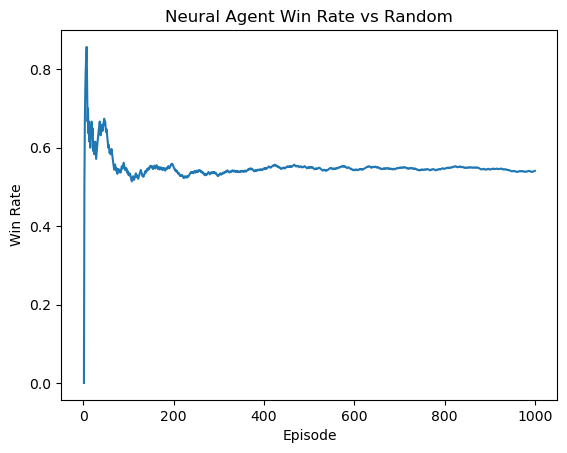

Model saved to battleship_agent.pth


In [143]:
# === Run Training and Save Model ===
if __name__ == '__main__':
    env = BattleshipEnv()
    agent = NeuralAgent(lr=1e-3)
    opponent = RandomAgent()
    episodes = 1000
    win_rates = train(agent, opponent, env, episodes)

    # Plot win rate over episodes
    plt.plot(range(1, episodes+1), win_rates)
    plt.xlabel('Episode')
    plt.ylabel('Win Rate')
    plt.title('Neural Agent Win Rate vs Random')
    plt.show()

    # Save the trained model
    torch.save(agent.net.state_dict(), 'battleship_agent.pth')
    print('Model saved to battleship_agent.pth')

In [145]:
win_rates[-1]

0.541

# Main

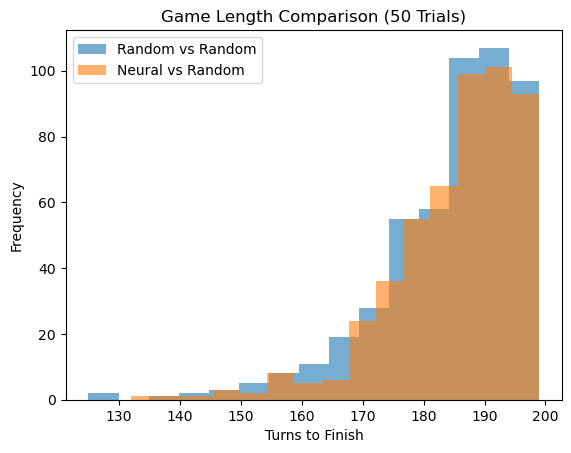

Avg Turns - Random vs Random: 184.65
Avg Turns - Neural vs Random: 185.43


In [149]:
# === Agents and Trial Runner ===

class RandomAgent:
    """Random baseline: picks an unopened tile uniformly."""
    def __init__(self):
        self.available = [(r,c) for r in range(BOARD_SIZE) for c in range(BOARD_SIZE)]

    def __call__(self, obs: np.ndarray) -> Tuple[int,int]:
        # obs: -1=miss,2=hit,0=unknown
        self.available = [xy for xy in self.available if obs[xy] == 0]
        choice = random.choice(self.available)
        self.available.remove(choice)
        return choice


def run_trials(
    agent1: Callable,
    agent2: Callable,
    trials: int = 1000
) -> Tuple[List[int], float]:
    """
    Run trials games, return list of turns and win percentage of agent1.
    """
    simulator = BattleShipSimulator()
    turns_list: List[int] = []
    wins = 0
    for _ in range(trials):
        a1 = agent1() if callable(agent1) else agent1
        a2 = agent2() if callable(agent2) else agent2
        winner, turns = simulator.play_game(a1, a2)
        turns_list.append(turns)
        if winner == 'player1':
            wins += 1
    win_pct = wins / trials * 100
    return turns_list, win_pct

# === Example Usage ===
if __name__ == '__main__':
    turns, win_pct = run_trials(RandomAgent, RandomAgent, trials=1000)
    # Plot histogram
    plt.hist(turns, bins=20, alpha=0.7)
    plt.xlabel('Turns to Finish')
    plt.ylabel('Frequency')
    plt.title(f'Random vs Random: Win%={win_pct:.1f}%')
    plt.show()
